# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using Printf
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using StatsPlots
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../util.jl")
includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums

In [40]:
# System parameters
sys_mass = 2.0
sys_length = 1.0
sys_damping = 0.2
sys_mnoise_sd = 1e-2
sys_ulims = (-50., 50.)
Δt = 0.2

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.0015049463526799738, 0.0, (-50.0, 50.0), 0.2, 2.0, 1.0, 0.2, 0.01)

In [41]:
N = 300
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:59.8

In [42]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [43]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

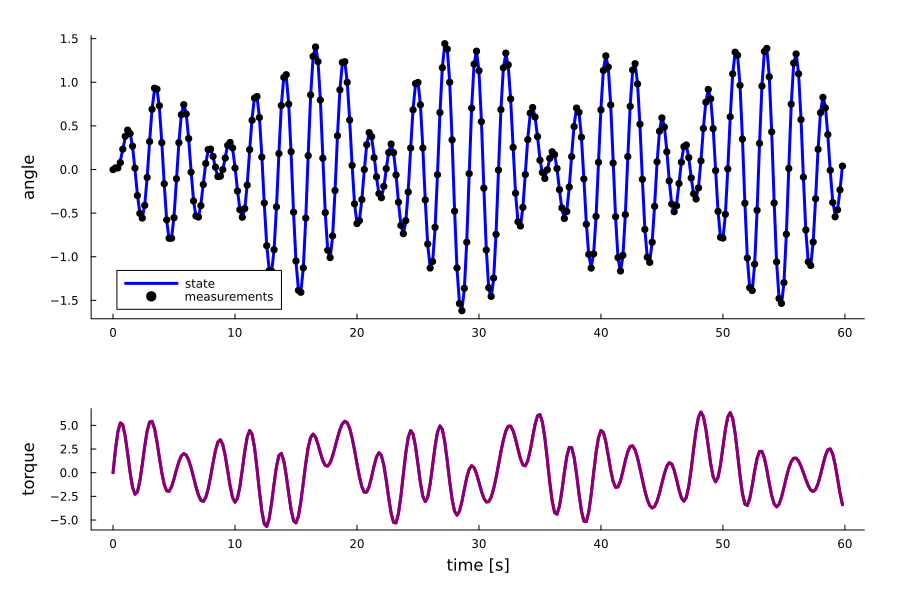

In [44]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Test model

In [45]:
# NARX settings
H = 2
Ly = 3
Lu = 3
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# Specify prior distributions
α0 = 10.0
β0 = 0.5
μ0 = 1e-3*ones(M)
Λ0 = 0.1*diagm(ones(M))
goal = Normal(3.14, 0.5)

T = 10

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

NARXAgent([0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], 3, 3, 2, 15, [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1], 10.0, 0.5, 0.0, Normal{Float64}(μ=3.14, σ=0.5), 10, 10, Inf)

In [46]:
py = []
μ = [μ0]
Λ = [Λ0]
α = [α0]
β = [β0]
FE = zeros(N)

torques_ = [torques; zeros(T)]
@showprogress for k in 1:N
    
    # Make predictions
    push!(py, predictions(agent, torques_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], torques[k])
    push!( μ, agent.μ )
    push!( Λ, agent.Λ )
    push!( α, agent.α )
    push!( β, agent.β )
    FE[k] = agent.free_energy
    
end

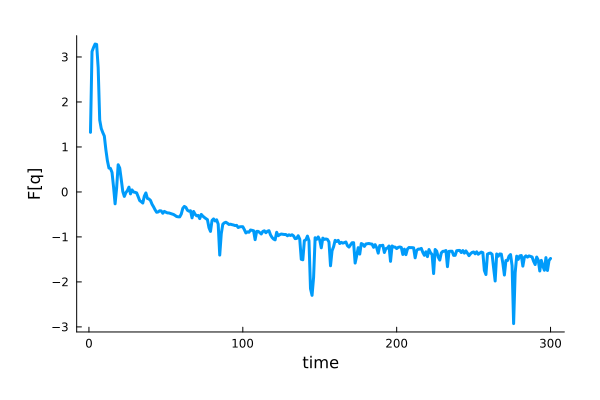

In [47]:
plot(FE, xlabel="time", ylabel="F[q]")

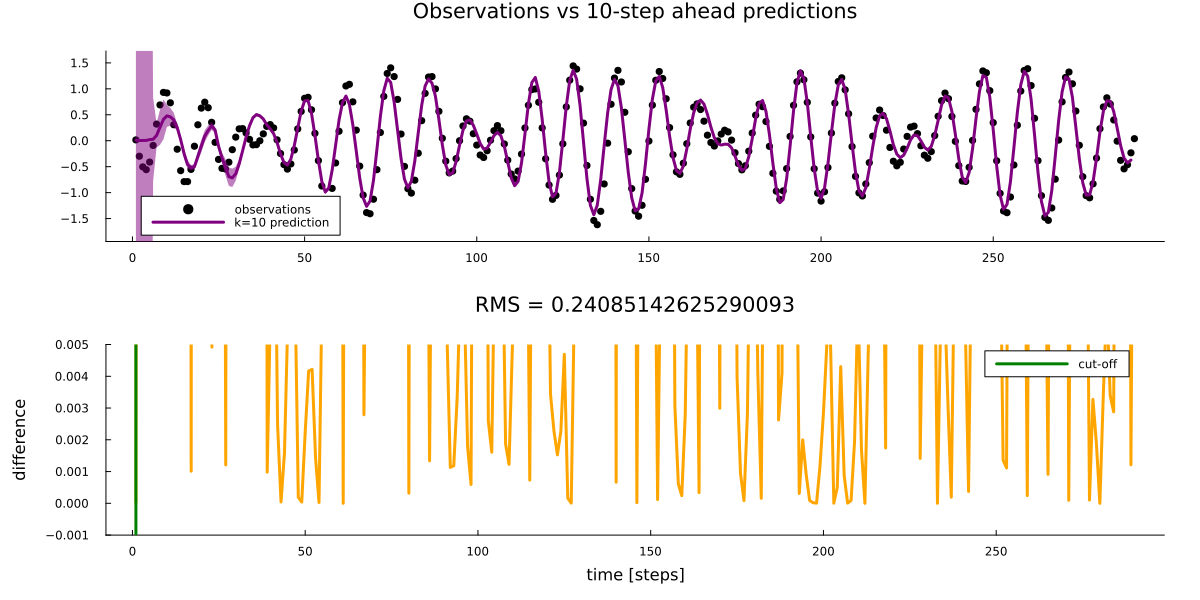

In [48]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 10

residuals = (observations[K:K+(N-T)-1] .- [py[k][1][K] for k in 1:(N-T)]).^2
cutoff = 1
RMS = sqrt(mean((residuals[cutoff:end])))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:N], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=(-0.001, 0.005))
plot!(residuals[1:(N-T)], title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

## Experiments

In [54]:
# Experiment specification 
N = 120
tsteps = range(0.0, step=Δt, length=N)
T = 5

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 100.0
β0 = 0.5
μ0 = 1e-2*randn(M)
Λ0 = 1e-3*diagm(ones(M))
λ = 1e-2

0.01

### Expected Free Energy minimization

In [55]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
goals = [Normal(Float64(π), 100) for t in 1:T]
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
ppy_EFE = zeros(N)

predy_k = (0.0, 100.)

@showprogress for k in 1:N    
    
    # Retrieve new observation
    y_EFE[k] = pendulum.sensor

    # Check prediction
    ppy_EFE[k] = -logpdf(Normal(predy_k[1], sqrt(predy_k[2])), y_EFE[k])
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )

    goals = [Normal(Float64(π), 100 ./ (k^2)) for t in 1:T]
    agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy

    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    predy_k = (pred_m[k,1], pred_v[k,1])

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


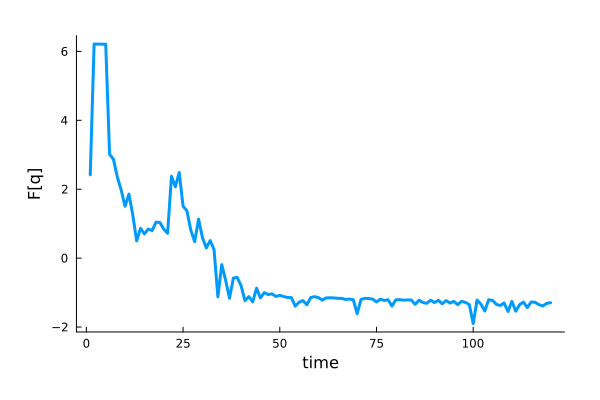

In [56]:
plot(F_EFE, xlabel="time", ylabel="F[q]")

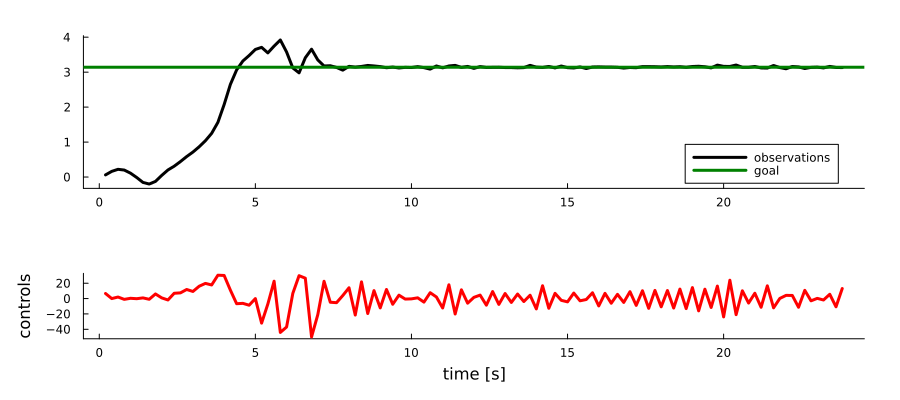

In [57]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/demo/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/demo/figures/NARX-EFE-1Pendulum-planning.gif")
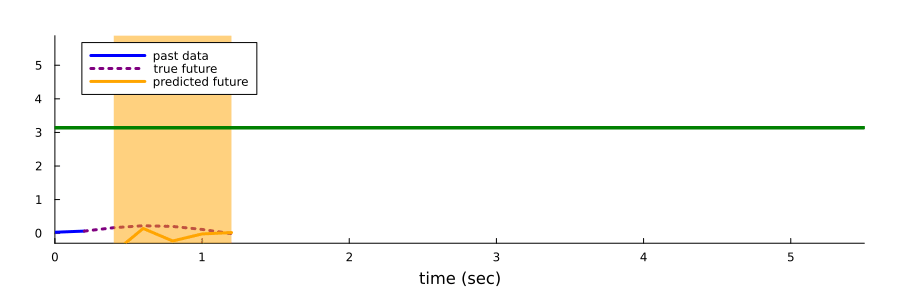

In [58]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!(mean.(goals), ribbon=std.(goals), fillalpha=0.05, color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!(mean.(goals), ribbon=std.(goals), fillalpha=0.05, color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/demo/figures/spendulum-trial.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/demo/figures/spendulum-trial.gif")
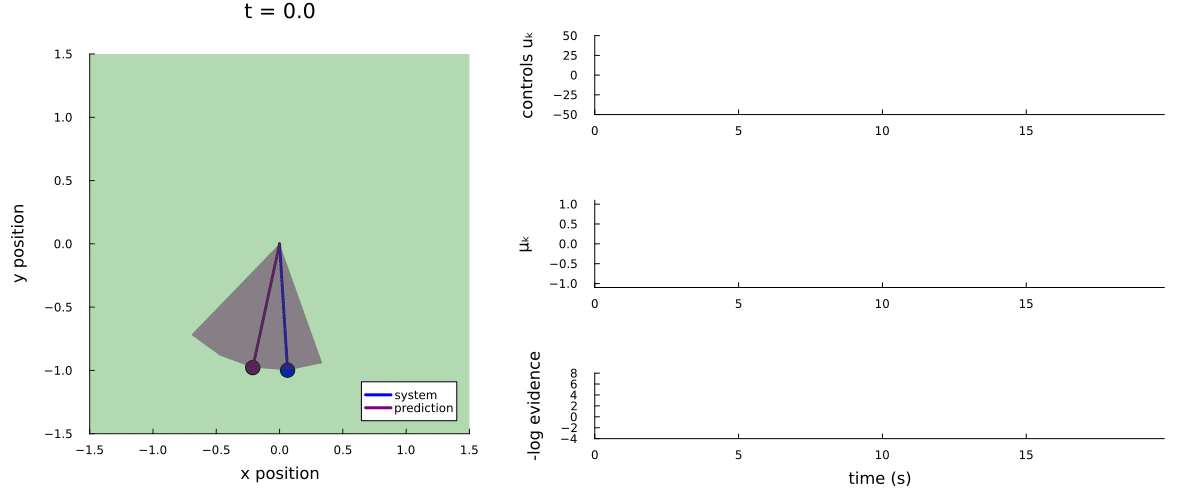

In [80]:
xlims = [-sys_length-0.5, sys_length+0.5]
ylims = [-sys_length-0.5, sys_length+0.5]

tsteps = range(0.0, step=Δt, length=100)

μ_trial = hcat(μ_EFE[2:end]...)'

lay = @layout [a{0.4w} [b{0.3h}; c{0.4h}; d{0.3h}]]

anim = @animate for (i,t) in enumerate(tsteps)
   
    # Cartesian positions
    px,py = polar2cart(z_EFE[1,i], sys_length)
    hx,hy = polar2cart(pred_m[i,1], sys_length)
    l1x,l1y = polar2cart(pred_m[i,1]-1/2*sqrt(pred_v[i,1]), sys_length)
    l2x,l2y = polar2cart(pred_m[i,1]-sqrt(pred_v[i,1]), sys_length)
    u1x,u1y = polar2cart(pred_m[i,1]+1/2*sqrt(pred_v[i,1]), sys_length)
    u2x,u2y = polar2cart(pred_m[i,1]+sqrt(pred_v[i,1]), sys_length)
    gx,gy = polar2cart(mean(goals[1]), sys_length)
    
    # Concatenate
    pen_k = [0 0; px py]
    ph_k  = [0 0; hx hy]
    goalp = [0 0; gx gy]
    
    # Plot line
    p1 = plot(pen_k[:,1], pen_k[:,2], label="system", title=@sprintf("t = %.1f", t), aspect_ratio=:equal, xlims=xlims, ylims=ylims, color="blue")
    
    # Point masses
    scatter!([pen_k[2,1]], [pen_k[2,2]], markersize=8, color="blue", alpha=1., xlabel="x position", ylabel="y position")

    plot!(ph_k[:,1], ph_k[:,2], color="purple", label="prediction")
    scatter!([ph_k[2,1]], [ph_k[2,2]], markersize=8, color="purple", alpha=1.)

    beam = Shape([(0.,0.), (l2x,l2y), (l1x, l1y), (hx,hy), (u1x,u1y), (u2x,u2y), (0.,0.)])
    plot!(beam, fillcolor="purple", linewidth=0, fillalpha=0.5)

    covellipse!([gx, gy], (100 / (i^2))*diagm(ones(2)), n_std=1, color="green", legend=:bottomright)

    p2 = plot(tsteps[1:i], u_EFE[1:i], xlims=[tsteps[1], tsteps[end]], ylims=sys_ulims, color="red", ylabel="controls uₖ")

    p3 = plot(tsteps[1:i], μ_trial[1:i,:], ylabel="μₖ", xlims=[tsteps[1], tsteps[end]], ylims=[-1.1,1.1])

    p4 = plot(tsteps[1:i], ppy_EFE[1:i],xlabel="time (s)", xlims=[tsteps[1], tsteps[end]], ylims=[-4,8], color="black", ylabel="-log evidence")

    plot(p1,p2,p3,p4, layout=lay, size=(1200,500))
    
end
gif(anim, "figures/spendulum-trial.gif", fps=10)

### Information-seeking

In [17]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

goals = [Normal(Float64(π), 1e8) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
ppy_EFE = zeros(N)

predy_k = (0.0, 100.)

@showprogress for k in 1:N    
    
    # Retrieve new observation
    y_EFE[k] = pendulum.sensor

    # Check prediction
    ppy_EFE[k] = -logpdf(Normal(predy_k[1], predy_k[2]), y_EFE[k])
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    predy_k = (pred_m[k,1], pred_v[k,1])

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


### Mean Squared Error minimization

In [18]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
F_MSE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
goals = [Normal(3.14, 1.0) for t in 1:T]
# gvars = 10 .^range(3, stop=-3, length=N)
# gvars = [1e3 for k in 1:N]

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )

    # # Move goal closer
    # goal_k = NormalMeanVariance(3.14, gvars[k])
    # update_goals!(goals, goal_k)
    # agent.goals = goals
    
    # Optimal control
    policy = minimizeMSE(agent, goals, control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_MSE[k+1])
    z_MSE[:,k] = pendulum.state
    
end

Progress:  11%|████▌                                    |  ETA: 0:01:19

InterruptException: InterruptException:

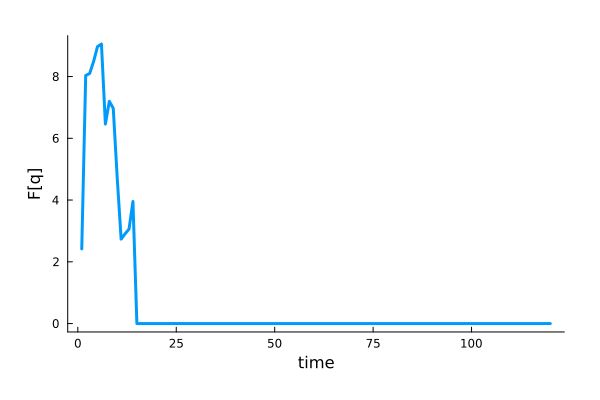

In [19]:
plot(F_MSE, xlabel="time", ylabel="F[q]")

In [20]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [21]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

BoundsError: BoundsError: attempt to access 99-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [1:119]

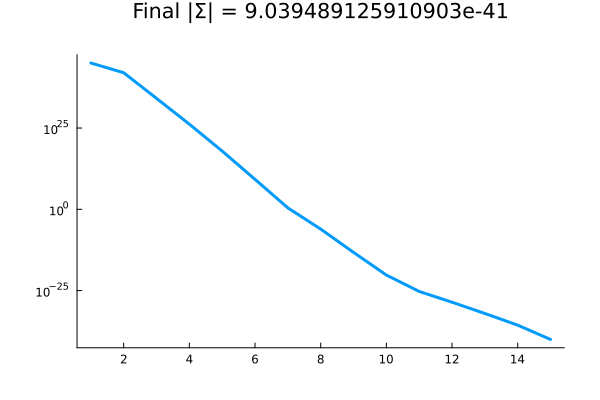

In [22]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

In [23]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

BoundsError: BoundsError: attempt to access 100-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [102]

### Comparisons

In [24]:
p1 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_MSE[2:end], linewidth=5, color=palette(:tab10)[2], label="MSE")

p2 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_EFE[2:end], linewidth=5, color=palette(:tab10)[3], label="EFE")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
# p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", )

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [25]:
savefig("figures/compare-trials.png")

BoundsError: BoundsError: attempt to access 99-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [1:119]

In [26]:
p1 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_MSE[2:end-T], linewidth=3, color=palette(:tab10)[2], label="MSE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

p2 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_EFE[2:end-T], linewidth=3, color=palette(:tab10)[3], label="EFE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [27]:
savefig("figures/compare-controls.png")

BoundsError: BoundsError: attempt to access 99-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [1:119]

In [28]:
println("Final sum of eigenvalues of Σ_θ for MSE = $final_dSθ_MSE")
println("Final sum of eigenvalues of Σ_θ for EFE = $final_dSθ_EFE")

Final sum of eigenvalues of Σ_θ for MSE = 9.039489125910903e-41


UndefVarError: UndefVarError: `final_dSθ_EFE` not defined

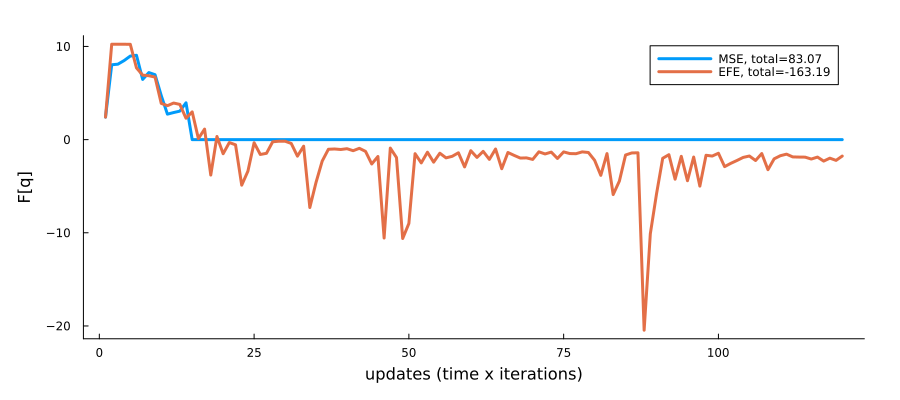

In [29]:
sF_MSE = round(sum(F_MSE[:]), digits=2)
sF_EFE = round(sum(F_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(F_MSE[:], label="MSE, total=$sF_MSE")
plot!(F_EFE[:], label="EFE, total=$sF_EFE")

In [30]:
# evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
# evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

# total_evidence_MSE = round(sum(evidence_MSE), digits=2)
# total_evidence_EFE = round(sum(evidence_EFE), digits=2)

# plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
# plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
# plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

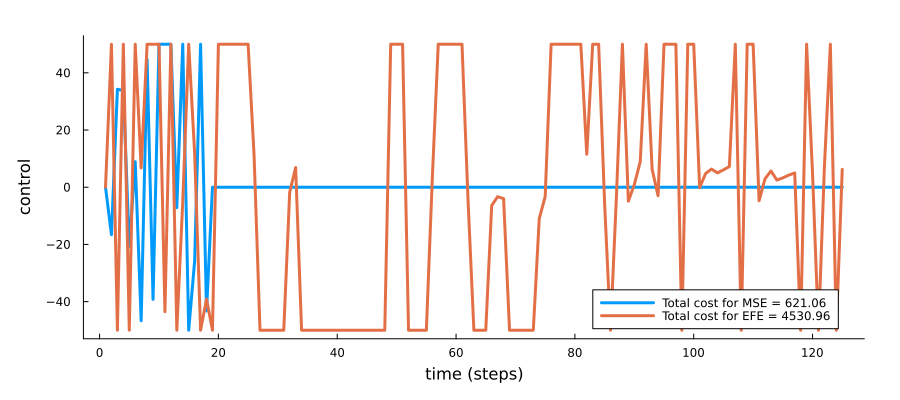

In [31]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

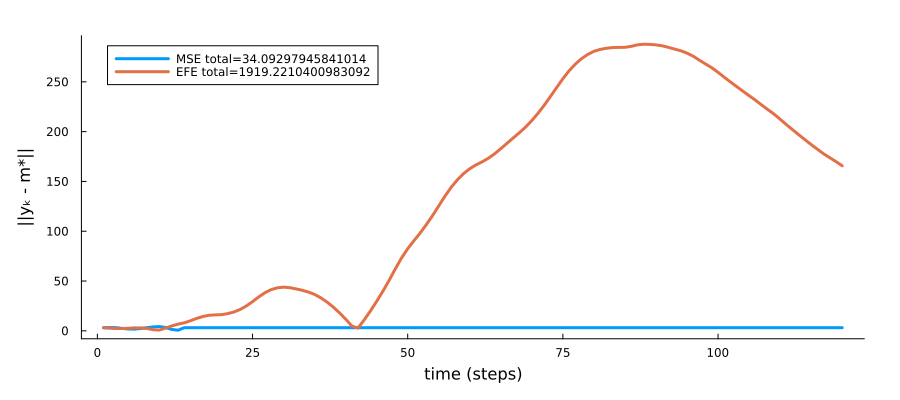

In [32]:
J_MSE = [norm(y_MSE[k] - mean(goals[1]),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goals[1]),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goals[1]),2)
sJ_EFE = norm(y_EFE .- mean(goals[1]),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")